# Evaluation des Neuronalen Netzes zur Giraffenpuzzle-Erkennung
Das Notebook [Giraffenpuzzle-Training](https://www.kaggle.com/code/toedtlifhsg/giraffenpuzzle-training?scriptVersionId=187781292) produzierte als Ausgabe ein fertig trainiertes neuronales Netz, sowie eine Aufsplittung des Giraffenpuzzleteile-Datensatzes in einen Trainings- und einen Testdatensatz. Hier wollen wir das Modell laden und auf dem Testdatensatz evaluieren.

In [1]:
import matplotlib.pyplot as plt #Plottingroutinen zur Visualisierung
import numpy as np # Arrays- "The fundamental package for scientific computing with Python" 
import pandas as pd #Umgang mit Tabellen- hier nur zum Laden der Klassenlabels
import tensorflow as tf #Tensorflow, trainieren von neuronale Netzen (inkl. Keras)
import shutil # Dateisystemmanipulationen, insbesondere für das Kopieren von Dateien
from pathlib import Path #Pathlib, Umgang mit Dateipfaden
import scikitplot # Visualisierungen von Klassifikationsperformanz

2025-10-30 17:56:12.012263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 17:56:12.012441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 17:56:12.177588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Baumstruktur_schon_vorhanden=True

In [3]:
# Modell laden:
loaded_model = tf.keras.models.load_model('/kaggle/input/giraffenpuzzle_beispielmodell/keras/baseline/1/model_Giraffe.keras')
# Excel-Datei mit Angabe, ob ein Bild ein Test- oder ein Trainingsbild ist:

In [4]:
Baumstruktur_schon_vorhanden

True

In [5]:
if Baumstruktur_schon_vorhanden:
    testBaumstrukturpfad = Path('/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test') #MUSS ANGEPASST WERDEN
    np.set_printoptions(suppress=True, linewidth=500)
    testBilder_fn = pd.Series([fn for fn in testBaumstrukturpfad.glob('*/*')])
    testKlassenlabel = pd.Series([fn.parent.name for fn in testBilder_fn],index=[fn.name for fn in testBilder_fn])
    y_test = testKlassenlabel
else:
    train_or_test = pd.read_excel('/kaggle/input/giraffenpuzzle_beispielmodell/keras/baseline/1/train_test_split.xlsx') #MUSS ANGEPASST WERDEN
    train_or_test.columns = ['Dateiname','TrainOrTest']
    
    testBilder_fn = train_or_test[train_or_test['TrainOrTest']=='test' ]

    # Extrahiere Klassenlabel aus Dateiname
    testKlassenlabel = train_or_test.Dateiname.map(lambda s:s[:s.find('_')])
    train_or_test['Klasse'] = testKlassenlabel
    testBilder_fn = pd.Series(train_or_test[train_or_test['TrainOrTest']=='test' ])

    # Wähle nur die Testdaten
    y_test = testKlassenlabel[ train_or_test['TrainOrTest']=='test' ]

    testBilder_fn=[]
    # Kopiere die Testbilder in eine Baumstruktur
    for irow,row in testBilder_fn.iterrows():
        Dateiname,TrainOrTest,Klasse = (row.Dateiname,row.TrainOrTest,row.Klasse)
        fullfilename = Path('/kaggle/input/giraffenpuzzleteile')/Dateiname
        testBaumstrukturpfad = Path('/kaggle/working')/'test'
        (testBaumstrukturpfad/Klasse).mkdir(exist_ok=True,parents=True)
        shutil.copyfile(fullfilename,testBaumstrukturpfad/Klasse/Dateiname)
        testBilder_fn.append(testBaumstrukturpfad/Klasse/Dateiname)
    testBilder_fn = pd.Series(testBilder_fn)
y_test = pd.Series(y_test.values,index=testBilder_fn)

In [6]:
y_test

/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-10/rot-10_0_13.jpg             rot-10
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-10/rot-10_0_18.jpg             rot-10
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-10/rot-10_0_14.jpg             rot-10
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-10/rot-10_0_02.jpg             rot-10
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-10/rot-10_0_09.jpg             rot-10
                                                                                                                             ...    
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/orange-02/orange-02_0_04.jpg    orange-02
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_outpu

Überprüfen wir das Resultat:

In [7]:
!ls {testBaumstrukturpfad}
#!ls /kaggle/working/test/*   #Ausgabe ist etwas lang, aber nützlich für die Überprüfung der Vollständigkeit
print('-'*70) #nur zur visuellen Strukturierung; 3*"a" ergibt "aaa"
!ls {testBaumstrukturpfad}/gelb-09

blau-05  cyan-04  cyan-14  gelb-09  orange-02  rosa-15	rot-16
blau-11  cyan-07  cyan-18  gelb-13  orange-08  rot-03	rot-17
blau-19  cyan-12  gelb-01  gelb-20  rosa-06    rot-10
----------------------------------------------------------------------
gelb-09_0_04.jpg  gelb-09_0_14.jpg  gelb-09_0_20.jpg
gelb-09_0_05.jpg  gelb-09_0_15.jpg


test_ds ist eine `tf.Dataset` ist eine Instanz einer Tensorflowklasse, welche effizient Trainingsbilder aus der Baumstruktur lädt. Natürlich ist das eigentlich erst bei grossen Datenmengen relevant, aber wir zeigen hier den Code. Wir könnten auch wieder `tf.keras.utils.image_dataset_from_directory` benutzen, aber dann würden wir den zugehörigen Dateipfad nicht erhalten. Nicht schlimm, aber wir könnten die Bilder nicht nochmals mit ihrem Label und Dateipfad zusammen anzeigen.

In [8]:
def lade_testdaten_mit_pfad(baumstrukturpfad, image_size=(64, 64), batch_size=32, suffix='.jpg',shuffle=False):
    """
    Diese Funktion baut ein tf.Dataset basierend auf den Daten in der Baumstruktur baumstrukturpfad, welches effizient Bilddaten in das neuronale Netz füttert.
 
    """
    # Alle Bildpfade erfassen
    all_files = sorted(list(Path(baumstrukturpfad).rglob("*/*"+suffix)))  # ggf. .png anpassen
    class_names = sorted({p.parent.name for p in all_files})
    label_map = {name: idx for idx, name in enumerate(class_names)}

    # Pfade und Labels vorbereiten
    file_paths = np.array([str(p) for p in all_files])
    labels = np.array([label_map[Path(p).parent.name] for p in file_paths])
    
    def lade_bild(pfad, label):
        image = tf.io.read_file(pfad)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, image_size)
        return image, label, pfad
        
    if shuffle:
        # Gleicher Shuffle-Index für beide
        shuffle_idx = np.random.permutation(len(file_paths))
        # Koordiniert shuffeln
        file_paths_shuffled = file_paths[shuffle_idx]
        labels_shuffled = labels[shuffle_idx]
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths_shuffled, labels_shuffled))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds,file_paths_shuffled, labels_shuffled, class_names
    else:
        # Dataset bauen
        ds_fn = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        ds = ds_fn.map(lade_bild).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds, file_paths, labels, class_names

    
test_ds, test_paths, y_test, class_names = lade_testdaten_mit_pfad(testBaumstrukturpfad, image_size=(64,64), batch_size=32, suffix='.jpg',shuffle=False)
test_ds,test_paths.shape,y_test.shape

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>,
 (89,),
 (89,))

Wir können uns ein paar Bilder, ihre Labels und die zugehörigen Dateinamen anschauen:

Text(0.5, 1.0, 'cyan-12 — cyan-12_0_06.jpg')

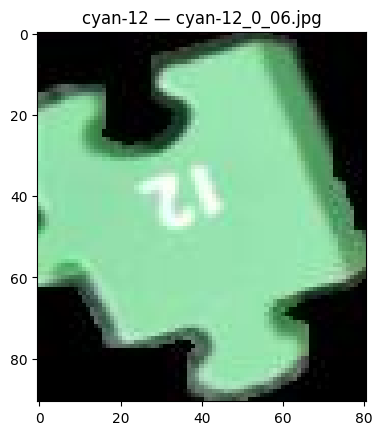

In [9]:
i=np.random.randint(test_paths.shape[0])
bild = plt.imread(test_paths[i])
label = class_names[y_test[i]]
plt.imshow(bild)
plt.title(f"{label} — {Path(test_paths[i]).name}")

In [10]:
yhat_test = loaded_model.predict(test_ds)
yhatnum_test = yhat_test.argmax(axis=1)

yhat_test.shape,y_test.shape


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


((89, 20), (89,))

In [11]:
y_test,yhatnum_test

(array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19]),
 array([ 0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  3,  5,  5,  5,  5,  3,  5,  3,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8, 11,  8,  9,  9,  9, 10,  9, 10, 10, 11, 10, 11, 11, 11, 11, 12, 13, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 17, 19, 19, 17, 17, 17, 19, 17, 17, 17, 17, 19, 19, 19, 19]))

Das ist nun also der Klassenindex- da wir die Bilder nicht "geshuffled" haben, ist zumindest die Sequenz `y_test` monoton. Bei `yhatnum_test` (also unseren Vorhersagen auf diesen Bildern) gibt es einige wenige Abweichungen. Das ist zu erwarten. Wenn wir nur wüssten, welcher Klasse das zugehört?!  
Aber weil wir zu neugierig sind, wie gut das Modell sein könnte, rechnen wir ohne dieses Wissen mal die Genauigkeit aus:

In [12]:
Genauigkeit = np.mean(np.where(y_test==yhatnum_test,1,0)) 
# np.where könnte man auch weglassen, so: Genauigkeit = np.mean(y_test==yhatnum_test). 
# Aber was ist der Mittelwert von True, False, True? 
# Klarer ist's wenn wir mit where ersetzen: True->1 und False->0
assert Genauigkeit==np.mean(y_test==yhatnum_test) # Ergibt einen Fehler, sollte das mal nicht mehr stimmen
print(f'Die Testgenauigkeit ist {100*Genauigkeit:3.1f}%.')

Die Testgenauigkeit ist 76.4%.


Nun würden wir also auch gerne die Label kennen. Wir müssen den Labelindex (die Zahl) mit dem Namen der Klasse in Verbindung bringen. Zum Glück werden die Klassenlabel sortiert durchgezählt, so dass dieser Schritt nicht schwer ist:

In [13]:
sorted_class_labels = np.array(sorted(testKlassenlabel.unique())) #Labels in Keras der Funktion image_dataset_from_directory werden immer alphanummerisch sortiert den Indices zugeordnet
sorted_class_labels

array(['blau-05', 'blau-11', 'blau-19', 'cyan-04', 'cyan-07', 'cyan-12', 'cyan-14', 'cyan-18', 'gelb-01', 'gelb-09', 'gelb-13', 'gelb-20', 'orange-02', 'orange-08', 'rosa-06', 'rosa-15', 'rot-03', 'rot-10', 'rot-16', 'rot-17'], dtype='<U9')

In [14]:
testBilder_fn
yhatnum_test

array([ 0,  0,  0,  0,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,  4,  4,  3,  5,  5,  5,  5,  3,  5,  3,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8, 11,  8,  9,  9,  9, 10,  9, 10, 10, 11, 10, 11, 11, 11, 11, 12, 13, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 17, 19, 19, 17, 17, 17, 19, 17, 17, 17, 17, 19, 19, 19, 19])

In [15]:
yhat_label = pd.Series(sorted_class_labels[yhatnum_test],index=test_paths)
y_test_label = pd.Series(sorted_class_labels[y_test],index=test_paths)
# das vorhergesagte Label:
yhat_label

/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_01.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_02.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_07.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_16.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_20.jpg    blau-05
                                                                                                                        ...   
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-16/rot-16_0_12.jpg       rot-10
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-17/rot-17_0_01.j

In [16]:
# und das Tatsächliche:
y_test_label

/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_01.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_02.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_07.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_16.jpg    blau-05
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/blau-05/blau-05_0_20.jpg    blau-05
                                                                                                                        ...   
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-16/rot-16_0_12.jpg       rot-16
/kaggle/input/giraffenpuzzle-test-zip/media/1_object_extraction_output/2_Baumstruktur_test/rot-17/rot-17_0_01.j

In [17]:
# Natürlich muss die gleiche Genauigkeit rauskommen, wenn wir sie mit den Labels berechnen, anstatt mit den Labelindices:
Genauigkeit2 = (yhat_label==y_test_label).mean()
print(f'Die Testgenauigkeit ist {100*Genauigkeit2:3.1f}%.')

Die Testgenauigkeit ist 76.4%.


Schliesslich können wir uns noch die Wahrscheinlichkeit merken, mit welcher das Neuronale Netz eine Klasse identifiziert hat. Dies ist also die grösste Zahl unter den $P(y=c_i|X)$ für alle Klassen $c_1$,...,$c_C$ ($C$ der Anzahl Klassen unseres Problems, `yhat_test.shape[1]`.

In [18]:
P = np.max(yhat_test,axis=1)
P.shape

(89,)

# Scikit-Plot
Wir sind bereit! Wir kennen die Testbilder, deren zugehörige Klassenlabel und Vorhersagen durch das geladene Modell. Wir folgen der Dokumentation [hier](https://scikit-plot.readthedocs.io/en/stable/metrics.html). Berechnen wir Metriken! Wir beginnen mit der Confusion Matrix:

              precision    recall  f1-score   support

     blau-05       1.00      1.00      1.00         5
     blau-11       0.00      0.00      0.00         4
     blau-19       0.56      1.00      0.71         5
     cyan-04       0.62      1.00      0.77         5
     cyan-07       1.00      0.75      0.86         4
     cyan-12       1.00      0.83      0.91         6
     cyan-14       1.00      0.75      0.86         4
     cyan-18       1.00      1.00      1.00         5
     gelb-01       1.00      0.80      0.89         5
     gelb-09       1.00      0.80      0.89         5
     gelb-13       0.75      0.75      0.75         4
     gelb-20       0.67      1.00      0.80         4
   orange-02       1.00      0.75      0.86         4
   orange-08       0.83      1.00      0.91         5
     rosa-06       0.67      1.00      0.80         6
     rosa-15       0.00      0.00      0.00         3
      rot-03       0.00      0.00      0.00         3
      rot-10       0.50    

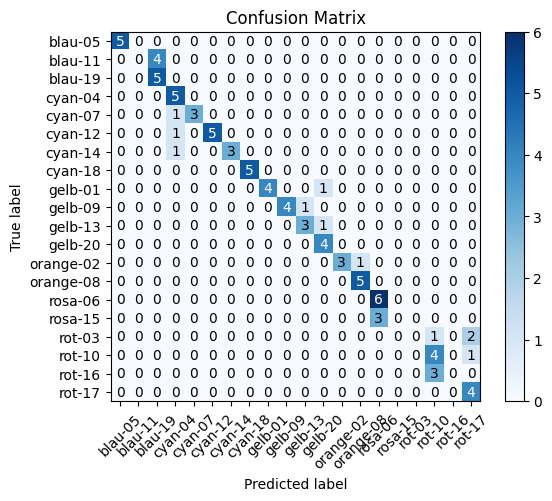

In [19]:
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test_label,yhat_label,zero_division=0))
plot_confusion_matrix(y_test_label,yhat_label,labels=sorted_class_labels,x_tick_rotation=45);

Beachten Sie, wie hübsch blockdiagonal die confusion matrix geworden ist. Dies zeigt, dass das Modell sich meist in der Form, und selten bis nie in der Farbe irrt.  
Ein offensichtliches Problem ist natürlich, dass wir den Grossteil der Daten zum Training benutzt haben (das ist gängige Praxis), und nun nur wenige Beispiele (pro Klasse) übrig haben, um die Präzision und den Recall der Klasse zu schätzen. Mehr Daten wären schon praktisch...

In [20]:
display((y_test_label==yhat_label).value_counts())
print('-'*30)
for curr_class_str in yhat_label.unique():
    curr_class_results=(y_test_label[y_test_label==curr_class_str]==yhat_label[y_test_label==curr_class_str])
    print(f'{curr_class_str:<10}:{100*curr_class_results.mean():3.0f}%')

True     68
False    21
Name: count, dtype: int64

------------------------------
blau-05   :100%
blau-19   :100%
cyan-04   :100%
cyan-07   : 75%
cyan-12   : 83%
cyan-14   : 75%
cyan-18   :100%
gelb-01   : 80%
gelb-20   :100%
gelb-09   : 80%
gelb-13   : 75%
orange-02 : 75%
orange-08 :100%
rosa-06   :100%
rot-10    : 80%
rot-17    :100%


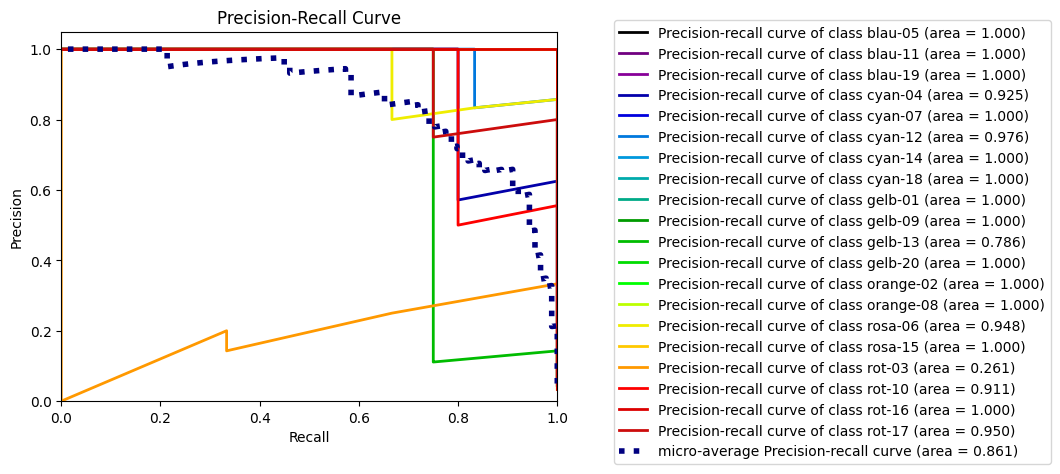

In [21]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_precision_recall(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

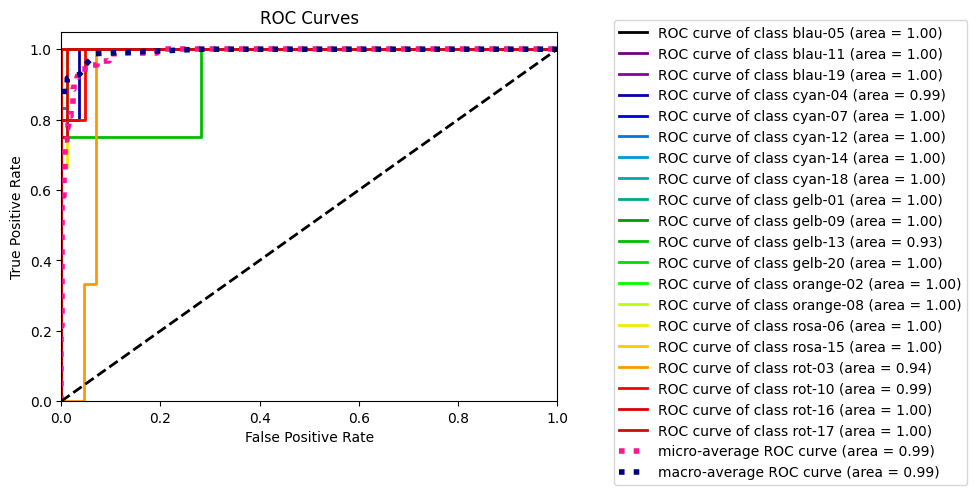

In [22]:
ax = plt.subplot(1,1,1)
scikitplot.metrics.plot_roc(y_test_label,yhat_test,ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05)); #Legende ausserhalb des Plots- sonst sieht man nichts

Ein Problem hier ist, dass das neuronale Netz für recht viele Klassen ("area=1.000") eine extreme Precision-Recall-Kurve ausgibt- von (0,1) über (1,1) nach (1,0). Aber wer würde sich schon darüber beklagen!

Zur Erinnerung, dies ist das Modell, das die obigen Resultate erziehlt hat. Wir können es grundsätzlich irgendwo (auf einem Raspberry-Pi?) laden und dort Vorhersagen generieren.

In [23]:
loaded_model.layers[-1]

<Dense name=Ausgabe, built=True>

In [24]:
loaded_model.summary()

Model: "Conv-Model-Standard"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Eingabe (InputLayer)            │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Ausgabe (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,651,742 (6.30 MB)

 Trainable params: 550,580 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,101,162 (4.20 MB)

# Conv Layer Outputs
In den nächsten paar Zeilen werden wir ("spasseshalber", ist nicht weiter wichtig), den Output der letzten Conv-Schicht ("conv2d_5") ausgeben und visualisieren.

In [25]:
conv_layer = loaded_model.get_layer("conv2d_3")

In [26]:
from tensorflow.keras import Model, Input

feature_model = Model(
    inputs=loaded_model.input,
    outputs=conv_layer.output,
    name="FeatureExtractor"
)


In [27]:
from PIL import Image
import numpy as np

color_image_size = (64, 64)

# Bild laden und skalieren
im = Image.open('/kaggle/input/giraffenpuzzleteile/gelb-09_0_02.jpg')
im_resized = im.resize(color_image_size, Image.Resampling.LANCZOS)
img = np.array(im_resized) / 255.0  # Normalisierung

# Batch-Dimension hinzufügen
img_batch = img.reshape(1, *color_image_size, 3)


In [28]:
feature_maps = feature_model.predict(img_batch)
print("Feature-Map Shape:", feature_maps.shape) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Feature-Map Shape: (1, 64, 64, 16)


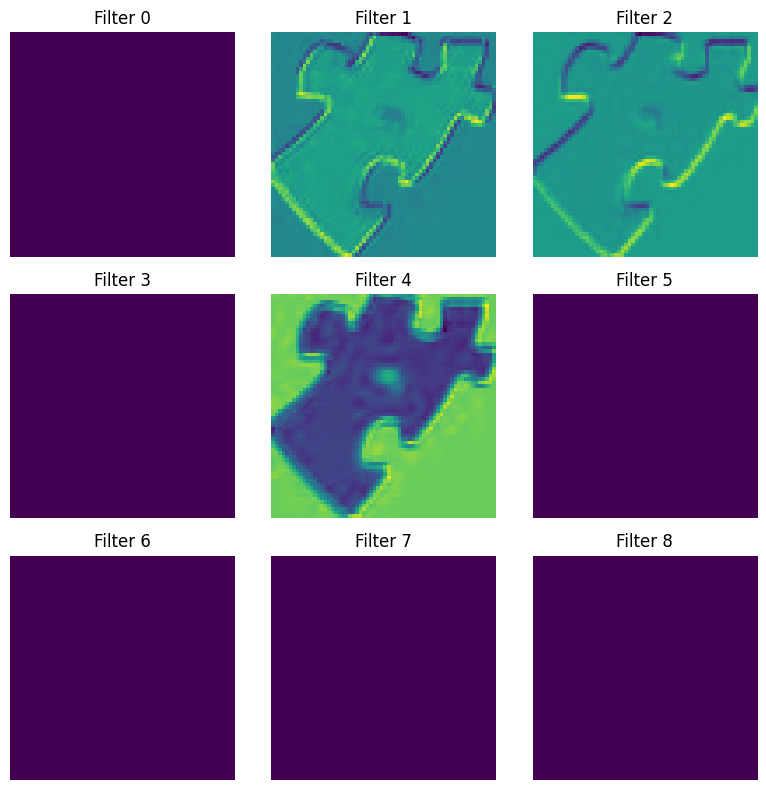

In [29]:
import matplotlib.pyplot as plt

# Einzeln anzeigen (z. B. die ersten 9 Kanäle)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, :, :, i], cmap='viridis')
    ax.set_title(f'Filter {i}')
    ax.axis('off')
plt.tight_layout()
plt.show()
